# Analyse input-ouput dynamique

Supposons que les techniques de production d'une économie soient telles que qu'il faille une quantité $a_{i,j}$ de marchandise $i$ (les _inputs_) pour produire une unité de la marchandise $j$ (l'_ouput_) avec $a_{i,j} \geq 0 $. Les rendements sont linéaires et les inputs doivent être fournis dans une proportion précise. On définit alors la _matrice des techniques_ $A = (a_{i,j})_{1 \leq i,j \leq n}$.

## 1. Inverse de Léontief

On suppose que les processus de production consomment tous les _inputs_ au cours d'un cycle synchronisé. Pour répondre à une demande $d \in \mathbb{R}_+^n$ donnée, il faut donc avoir une production brute $x \in \mathbb{R}_+^n$ qui vaut $d$ augmentée des _inputs_ consommés dans la production. En particulier, on a :
$$ x = Ax + d$$
et donc, en notant $I_n$ la matrice identité :
$$ x = (I_n - A)^{-1}d$$
si $(I_n - A)$ est inversible. Un théorème nous assure que, pour ce type de matrices, il faut et il suffit que le rayon spectral de $A$ soit strictement inférieur à 1 pour que $(I_n - A)$ soit inversible, d'inverse positive (dans le sens où chaque terme est positif).


#### _Exemple_

On définit la matrice des techniques suivante :
$$
A = \begin{pmatrix}
0.00 & 0.60 & 0.20 \\
0.25 & 0.00 & 0.55 \\
0.30 & 0.45 & 0.00 \\
\end{pmatrix}
$$
et la demande suivante : $$ d = \begin{pmatrix} 95 \\ 105 \\ 120 \\ \end{pmatrix}.$$

In [18]:
import numpy as np

def spectral_radius(M): #frobenius root
    eigen_values,eigen_vectors = np.linalg.eig(M)
    return max(np.absolute(eigen_values))

def leontiev_inverse(M):
    if spectral_radius(M)<1:
        N = np.identity(3) - M
        return np.linalg.inv(N)
    else:
        print("La matrice des techniques n'est pas productive.")

A = np.array([[0,0.6,0.2],[0.25,0,0.55],[0.3,0.45,0]])
d = np.array([95,120,100])
print("Le rayon spectral de A est",spectral_radius(A))
print("La production brute x est",np.dot(leontiev_inverse(A),d))

Le rayon spectral de A est 0.7827638400728136
La production brute x est [492.36935867 504.09738717 474.55463183]


## 2. Un premier modèle dynamique : le modèle de Goodwin
En considérant $x(t)$ la production brute décidée à la période discrète $t-1$ pour répondre à la demande du moment achevée à la période $t$ et une demande $d$ constante, on réécrit la première équation :
$$ x(t) = Ax(t-1) + d.$$
Heureusement, comme le rayon spectral est inférieur à 1, le système est assymptotiquement stable et converge vers $(I_n - A)^{-1}d$.

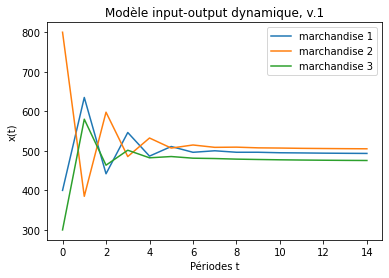

In [21]:
import matplotlib.pyplot as plt

A = np.array([[0,0.6,0.2],[0.25,0,0.55],[0.3,0.45,0]])
d = np.array([95,120,100])
x_0 = np.array([400,800,300])
t_max = 15
x = np.zeros((t_max,3))
x[0] = x_0

for t in range(1,t_max):
    x[t] = np.dot(A,x[t-1])+d

plt.plot(x)
plt.xlabel("Périodes t")
plt.ylabel("x(t)")
plt.title("Modèle input-output dynamique, v.1")
plt.legend(["marchandise 1","marchandise 2","marchandise 3"])
plt.show()
plt.close()

## 3. La séquence de Shiozawa-Morioka
L'objet du modèle S-M est d'analyser comment les firmes de chaque secteur $j$ adaptent leurs productions selon l'évolution de la demande qu'elles anticipent en supposant qu'elles ont une certaine flexibilité grace aux stocks et inventaires de matières premières et de produits finis qu'elles détiennent. L'idée du modèle est de s'éloigner des analyses « à l'équilibre » en modélisant explicitement une séquence temporelle des actions et réflexions des firmes. À chaque période discrète $t$, il se déroule la séquence suivante (qui est supposée relever de la _routine_ au sens de H. Simons et laisser du temps et de la reflexion aux managers de haut niveau pour les décisions stratégoqies. C'est donc un modèle de très court-terme):
1. Les firmes $ 1 \leq j \leq n$ actualisent les inventaires des produits qu'elles possèdent : $$z_j(t) = z_j(t-1) + x_j(t-1) - s_j(t-1)$$ où $s$ représente leurs ventes de la période précédente.
2. Les firmes font des prévisions de vente $s_j^e(t)$ puis décident le niveau de leur prochaine production : $$x_j(t) = (1+k_j)s_j^e(t) - z_j(t)$$ avec $k_j$ une petite marge de manoeuvre qui modélise ce qu'on appelle la stratégie _make-to-stock_ (MTS) en logistique.
3. Les firmes $j$ lancent la nouvelle production et actualisent leurs inventaires des _inputs_ $i$ : $$v_{i,j}(t) = v_{i,j}(t-1) + m_{i,j}(t-1) - a_{i,j}x_j(t)$$ avec $m_{i,j}(t-1)$ les inputs qu'elles ont commandé à la période précédente et avec la contrainte $v_{i,j}(t) \geq 0$. Sinon, elles doivent limiter leur production $x_j(t)$.
4. Les firmes $j$ commandent de nouveaux inputs $i$ :$$m_{i,j}(t) = (1+l_{j})a_{i,j}s_j^e(t) − v_{i,j}(t)$$ avec $l_{j}$ une peite marge de manoeuvre (la même au sein d'une firme $j$ pour tous les inputs $i$...).
5. Les firmes $j$ vendent et envoient ce qui leur a été commandé : $$s_j(t) = \sum_{i=1}^{n} m_{i,j}(t) + d_j$$ dans la mesure des stocks disponibles, c'est-à-dire si $s_j(t) \leq z_j(t) + x_j(t)$.

En notation matricielle, et en notant $L=\text{diag}(l_j)$ et $K=\text{diag}(k_j)$, on a :
$$
s(t) = (2I_n + K + L)A[s^e(t)-s^e(t-1)]+As(t-1)+d.
$$
Si les prévisions $s^e(t)$ sont constantes, on se ramène au premier système.

## Exploration du théorème de Scarff

In [17]:
import random as random

# Loi exponentielle

    #parametre = 0.01
    #mu = 1/parametre
    #sigma = 1/parametre
    #r = random.expovariate(parametre)
    
t_max = 54
    
z_0 = 100 #inventaire
x_0 = 80 #production
s_0 = 80 #ventes
d_0 = 80 #demande

c = 1 # coût unitaire constant (hypothèse importante dans le théorème de Scarff)
m = 0.2
p = c*(1+m)

y[t] = z[t-1] + x[t]
s[t] = min(y[t],d[t]) # « short-side rule » dans la terminologie d'Arrow et al.
z[t] = y[t] - s[t]

y_target = (1+k)mu # resultat de Scarff

x[t] = max(y_target - z[t],0)

38.79752723351859
